# 5. Getting representative 1sqkm squares

On step #3, we created 1sqkm squares that cover the entirety of each city (with some degree of overlap), as well as its tree coverage. On step #4, we computed how many people in each city lives in areas with different shares of tree coverage. On this notebook, we will combine both approaches to generate .geotiff images which span 1sqkm, and have a tree coverage similar to that of the most populated tree cover range.

We will also make a function to select the most populated square at different tree cover levels for each city.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

## 5.1 Selecting representative squares – where most people live

In [2]:
# First, let's load the hexagon information we computed in the previous step
hexbin_levels = pd.read_csv("../output/population-by-tree-coverage-bin.csv")

In [3]:
# Since we saved it as csv, the bounds are now in text and not in numpy objects.
# Let's solve that by extracting upper and lower bounds
# Step 1: Convert tr_pct_bin into numerical bounds
hexbin_levels[['tr_pct_bin_lower', 'tr_pct_bin_upper']] = hexbin_levels['tr_pct_bin'].str.extract(r'\[(.*),(.*)\)').astype(float)

In [4]:
# Now, for each city, let's keep only the row with the most populated tree coverage range
most_populated = hexbin_levels.loc[hexbin_levels.groupby(['city_id']).pop_ft_pct.idxmax()]

In [5]:
# Take a look at that in order
most_populated.sort_values(by='tr_pct_bin', ascending=False)

,city_id,tr_pct_bin,pop_ft,pop_ft_pct,UC_NM_MN,CTR_MN_NM,CTR_MN_ISO,continent,INCM_CMI,tr_pct_bin_lower,tr_pct_bin_upper
3213,8835.0,"[0.38, 0.4)",2.327518e+05,0.051525,Colombo,Sri Lanka,LKA,Asia,LMIC,0.38,0.40
492,530.0,"[0.36, 0.38)",2.542809e+04,0.082163,Nashville,United States,USA,Americas,HIC,0.36,0.38
2614,3675.0,"[0.34, 0.36)",8.077239e+05,0.054239,Moscow,Russia,RUS,Europe,UMIC,0.34,0.36
788,855.0,"[0.3, 0.32)",1.845908e+05,0.050220,Washington D.C.,United States,USA,Americas,HIC,0.30,0.32
1853,2973.0,"[0.28, 0.3)",1.058625e+05,0.070918,Stockholm,Sweden,SWE,Europe,HIC,0.28,0.30
...,...,...,...,...,...,...,...,...,...,...,...
2647,3798.0,"[0.0, 0.02)",1.260350e+06,0.443719,Lusaka,Zambia,ZMB,Africa,LMIC,0.00,0.02
2730,3902.0,"[0.0, 0.02)",1.947577e+07,0.832276,Cairo,Egypt,EGY,Africa,LMIC,0.00,0.02
2806,4220.0,"[0.0, 0.02)",8.993637e+05,0.323871,Maputo,Mozambique,MOZ,Africa,LIC,0.00,0.02
2835,4335.0,"[0.0, 0.02)",5.210299e+06,0.963118,Khartoum,Sudan,SDN,Africa,LMIC,0.00,0.02


In [6]:
# Now, let's read in the 1sqkm squares
squares = gpd.read_file("../output/earth_engine_exports/TreeCoverAnalysis-Boxes-26-08-24-17_26/TreeCoverAnalysis-Boxes-26-08-24-17_26.shp")

In [7]:
# Let's merge the squares with the most populated hexbins of each
most_populated_squares = squares.merge(
    most_populated[['city_id', 'UC_NM_MN', 'CTR_MN_NM', 'CTR_MN_ISO', 
                    'tr_pct_bin_lower', 'tr_pct_bin_upper', 'pop_ft_pct']], 
    on='city_id')

# And rename the columns to avoid confusion. Now, for each row, 
# I have the upper and lower bounds of a representative entry for the city.
most_populated_squares = most_populated_squares.rename(columns={"tr_pct_bin_lower": "city_lower_bound", "tr_pct_bin_upper": "city_upper_bound"})

In [8]:
# Keep only the squares that match the lower and upper bounds of the city
most_populated_squares = most_populated_squares[
    (most_populated_squares.tree_pct >= most_populated_squares.city_lower_bound) 
    & (most_populated_squares.tree_pct < most_populated_squares.city_upper_bound)
]

In [9]:
# Now, let's keep only the most populated cells of each
most_populated_squares = most_populated_squares.loc[most_populated_squares.groupby('city_id').pop_ft.idxmax()]

In [10]:
# With the hexagon_n of each square (remember they were originally created from hexagon centroids!)
# we can query Earth Engine to generate the desired images. However, we will do this at a later step.
# For now, let's save this information as a basic CSV that we can access later.
most_populated_squares = most_populated_squares[['city_id', 'hexagon_n', 'UC_NM_MN', 'CTR_MN_NM', 'CTR_MN_ISO',
                                                 'tree_pct', 'pop_ft_pct' ]]
most_populated_squares.to_csv("../output/representative-squares-most-populated.csv", index=False)

In [11]:
# A sneak peek at the results
most_populated_squares.head()

,city_id,hexagon_n,UC_NM_MN,CTR_MN_NM,CTR_MN_ISO,tree_pct,pop_ft_pct
56302,10.0,1814,San Jose,United States,USA,0.044148,0.160805
57325,79.0,606,Phoenix,United States,USA,0.029236,0.380979
59922,143.0,503,Ciudad Juárez,Mexico,MEX,0.003143,0.777965
60090,183.0,51,Anchorage,United States,USA,0.239431,0.132741
60144,288.0,11,Guatemala City,Guatemala,GTM,0.074076,0.083175


## 5.2 One square for each level, at each city

I want to get one image of each tree coverage level of a city. The problem is: for some city-coverage pairs, there are no matching squares, as they derive from the hexagons but have different value. To overcome this, I'll select the closest one out of the bin, when that is the case.

In [12]:
# Take the hexbins
hexbins = pd.read_csv("../output/earth_engine_exports/TreeCoverAnalysis-Hexagons-27-08-24-08_32.csv")

In [13]:
# Apply the same binning as the hexagons in each of the squares
step = .05
start, end = 0, 1 + step
bin_edges = np.arange(start, end, step)
hexbins['tr_pct_bin'] = pd.cut(hexbins['tree_pct'], 
                                      bins=bin_edges, include_lowest=True, right=False)

In [14]:
# This time, we will have to do some work-arounds to avoid
# generating values for empty bins.
# First, get the total population of each city.
city_populations = hexbins.groupby('city_id').pop_ft.transform('sum')

In [15]:
# Then, compute the share of population at each individual hexbin
hexbins['pop_ft_pct'] = hexbins.pop_ft / city_populations

In [17]:
# Count the total bins at each level-city
hexbin_counts = hexbins.groupby(['city_id', 'tr_pct_bin']).hexagon_n.count().reset_index().rename(
    columns={"hexagon_n": 'count'}
)

In [18]:
# Sums the percentage of population at each level-city
pop_shares = hexbins.groupby(['city_id', 'tr_pct_bin']).pop_ft_pct.sum().reset_index()

In [19]:
# Now hexbin_counts and pop_shares have the same index order.
# We can concat/merge them. Let's merge so we can be sure they are joined by value
pop_shares = pop_shares.merge(hexbin_counts)

In [20]:
# Take a look at city 5635. There are lots of entries with no hexagons!
pop_shares[pop_shares.city_id==5635]

,city_id,tr_pct_bin,pop_ft_pct,count
1980,5635.0,"[0.0, 0.05)",0.996943,281
1981,5635.0,"[0.05, 0.1)",0.002969,7
1982,5635.0,"[0.1, 0.15)",0.000087,1
1983,5635.0,"[0.15, 0.2)",0.000000,0
1984,5635.0,"[0.2, 0.25)",0.000000,0
1985,5635.0,"[0.25, 0.3)",0.000000,0
1986,5635.0,"[0.3, 0.35)",0.000000,0
1987,5635.0,"[0.35, 0.4)",0.000000,0
1988,5635.0,"[0.4, 0.45)",0.000000,0
1989,5635.0,"[0.45, 0.5)",0.000000,0


In [22]:
# They come from the intervals we made before. Let's drop them.
pop_shares = pop_shares[pop_shares['count'] > 0]

In [24]:
# Now that we have only the entries we need.
# We can get the closest square for each level!
pop_shares.head()

,city_id,tr_pct_bin,pop_ft_pct,count
0,10.0,"[0.0, 0.05)",0.347187,854
1,10.0,"[0.05, 0.1)",0.305198,532
2,10.0,"[0.1, 0.15)",0.159283,311
3,10.0,"[0.15, 0.2)",0.070549,159
4,10.0,"[0.2, 0.25)",0.042637,103


In [25]:
# Defines and applies a function to get the closest
# square with the largest population.
# To be simple, it:
# - Tries to select a square in that bin. If there's more than one, get the most populous.
# - If there is no such square, gets the one closest to it in percentage terms.
def get_square(row, squares):
        
    # Scope copy of the squares
    squares_ = squares.copy()
    
    # Sorts by population
    squares = squares.sort_values(by='pop_ft', ascending=False)
    
    # Extracts minimum and maximum values
    lower_bound = row.tr_pct_bin.left
    upper_bound = row.tr_pct_bin.right
    center = round((lower_bound + upper_bound) / 2, 2)
    
    # Extracts city id
    city_id = row.city_id
    
    # Checks if there are squares in that bound
    subset = squares_[(squares_.tree_pct.between(lower_bound, upper_bound)) & (squares_.city_id==city_id)]
    
    # If there is a match
    if subset.shape[0] >= 1:

        # Saves the information
        square_id = subset.iloc[0]['hexagon_n']
        tree_pct = subset.iloc[0]['tree_pct']
        actual = True
        diff = round(abs(center - tree_pct), 2)
        
    else:
        
        # Computes the rounded, absolute difference between each square and the center of the interval
        squares_['diff'] = round(abs(squares_.tree_pct - center), 2)
        
        # Select the smallest diff
        min_diff = squares_['diff'].min()
    
        # Gets the first entry with the smallest diff (squares were sorted by pop already)
        subset = squares_[(squares_.city_id==city_id)].sort_values(by='diff')
        
        # Saves the information
        square_id = subset.iloc[0]['hexagon_n']
        tree_pct = subset.iloc[0]['tree_pct']
        actual = False
        diff = round(abs(center - tree_pct), 2)
        
    return pd.Series({
        'square_id': square_id,
        'tree_pct': tree_pct,
        'actual': actual,
        'diff': diff
    })
  
# Concatenates the original dataframe with the results
pop_shares = pd.concat([
    pop_shares,
    pop_shares.progress_apply(lambda row: get_square(row, squares), axis=1)
], axis=1)

  0%|          | 0/1732 [00:00<?, ?it/s]

In [26]:
# This is how the dataset looks like after selecting representative squares.
pop_shares.head()

,city_id,tr_pct_bin,pop_ft_pct,count,square_id,tree_pct,actual,diff
0,10.0,"[0.0, 0.05)",0.347187,854,0,0.026646,True,0.01
1,10.0,"[0.05, 0.1)",0.305198,532,1,0.063856,True,0.02
2,10.0,"[0.1, 0.15)",0.159283,311,10,0.133059,True,0.01
3,10.0,"[0.15, 0.2)",0.070549,159,4,0.182209,True,0.00
4,10.0,"[0.2, 0.25)",0.042637,103,44,0.208809,True,0.01


In [39]:
# Let's merge the selected squares back with their original 
pop_shares = pop_shares.merge(squares[['city_id', 'hexagon_n','geometry']], 
                 left_on=['city_id', 'square_id'], 
                 right_on=['city_id', 'hexagon_n'])

In [ ]:
# Here's how it looks like:
pop_shares.head()

<Axes: >

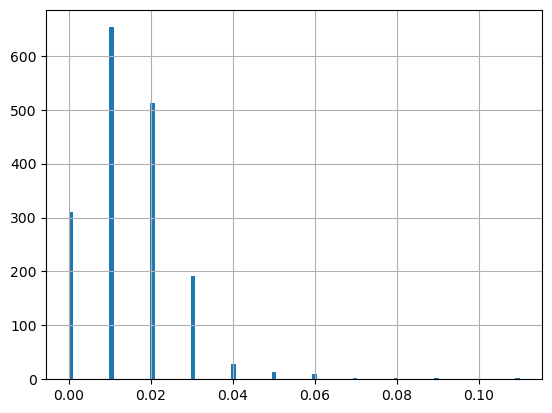

In [27]:
# A histogram of the differences from the center of the group.
# While most stay within small error margins, some have an 8% point difference.
# It's quite a lot, but not terrible.
pop_shares['diff'].hist(bins=100)

In [44]:
# And lets quickly check if all cities have around 100% of their population covered
# Apparently... yes, with some floating point error
pop_shares.groupby('city_id').pop_ft_pct.sum().value_counts()

pop_ft_pct
1.0    101
1.0     18
1.0      3
1.0      1
Name: count, dtype: int64

In [47]:
# We can now save this as a CSV, with the correct city and square ids.
pop_shares.to_csv("../output/bin_levels_squares_most_populated.csv", index=False)